## Time Series Analsyis of US Energy Information 

##### The data used shows the receipts of fossil fuels by electrictiy plants for all sectors in New York state

### This script contains:
##### 1. Importing your libraries and data
##### 2. Subsetting, wrangling, and cleaning time-series data
##### 3. Time series analysis: decomposition
##### 4. Testing for stationarity
##### 5. Stationarizing US Energy Information on Fossil Fuel Receipts
##### 6. Forecasting with ARIMA

### 1. Importing your libraries and data

In [48]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [49]:
# Configure API key 

quandl.ApiConfig.api_key = 'DWdFN7ysWCPB6skng1jr'

In [50]:
# Importing data from the US Energy Information Administration data, variable: "Receipts of fossil fuels by electricity plants ; natural gas ; New York ; all sectors ; monthly"

data = quandl.get('EIA/ELEC_RECEIPTS_NG_NY_99_M')

The reason for choosing this data: it shows another side to NY state's energy consumption, now looking into fossil fuel consumption. The data starts in 2008, and goes up to 2021, with no forecasted values. Because it is monthly data it is likely to have some seasonality. 

In [51]:
data.head(5)

,Value
Date,
2008-01-31,28637.792
2008-02-29,26530.254
2008-03-31,30553.781
2008-04-30,28445.590
2008-05-31,29732.058


In [52]:
data.shape

(167, 1)

In [53]:
data.columns

Index(['Value'], dtype='object')

In [54]:
type(data)

pandas.core.frame.DataFrame

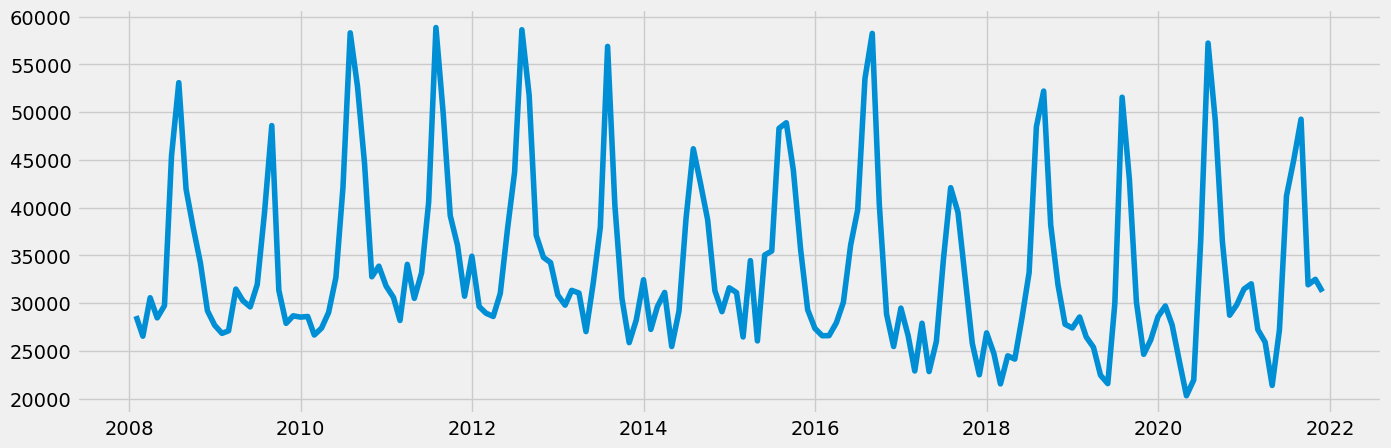

In [55]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

I will look into all records except for 2008, which is likely an outlie years since it matches the recession period, when energy consumption has generally dropped (and therefore receipts for fossil fuels are likely to have also lower values).

### 2. Subsetting, wrangling, and cleaning time-series data

In [56]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [57]:
data_2.head()

,Date,Value
0,2008-01-31,28637.792
1,2008-02-29,26530.254
2,2008-03-31,30553.781
3,2008-04-30,28445.590
4,2008-05-31,29732.058


In [58]:
data_sub = data_2.loc[(data_2['Date'] > '2008-12-31')] #sub-setting by excluding 2008 records only

In [59]:
data_sub.shape

(155, 2)

In [60]:
data_sub.head(8)

,Date,Value
12,2009-01-31,26823.643
13,2009-02-28,27090.215
14,2009-03-31,31458.670
15,2009-04-30,30244.911
16,2009-05-31,29595.668
17,2009-06-30,31934.077
18,2009-07-31,39471.685
19,2009-08-31,48586.491


In [61]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2009-01-31,26823.643
2009-02-28,27090.215
2009-03-31,31458.670
2009-04-30,30244.911
2009-05-31,29595.668


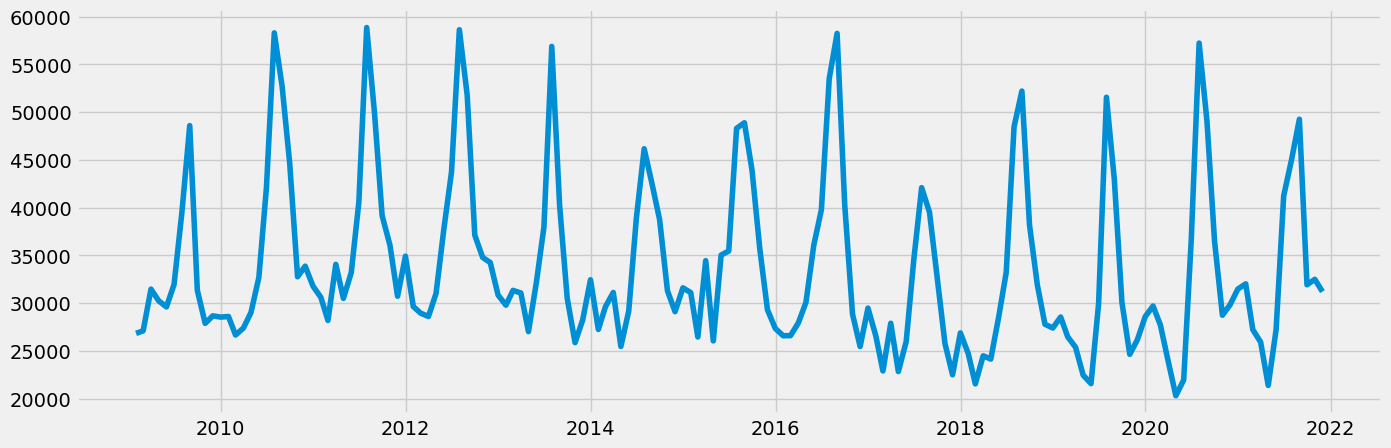

In [62]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

The data has first an upward trend than a downward trend, it does not appear stationary

In [63]:
# Check for missing values 

data_sub.isnull().sum() 

Value    0
dtype: int64

In [64]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [65]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [66]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

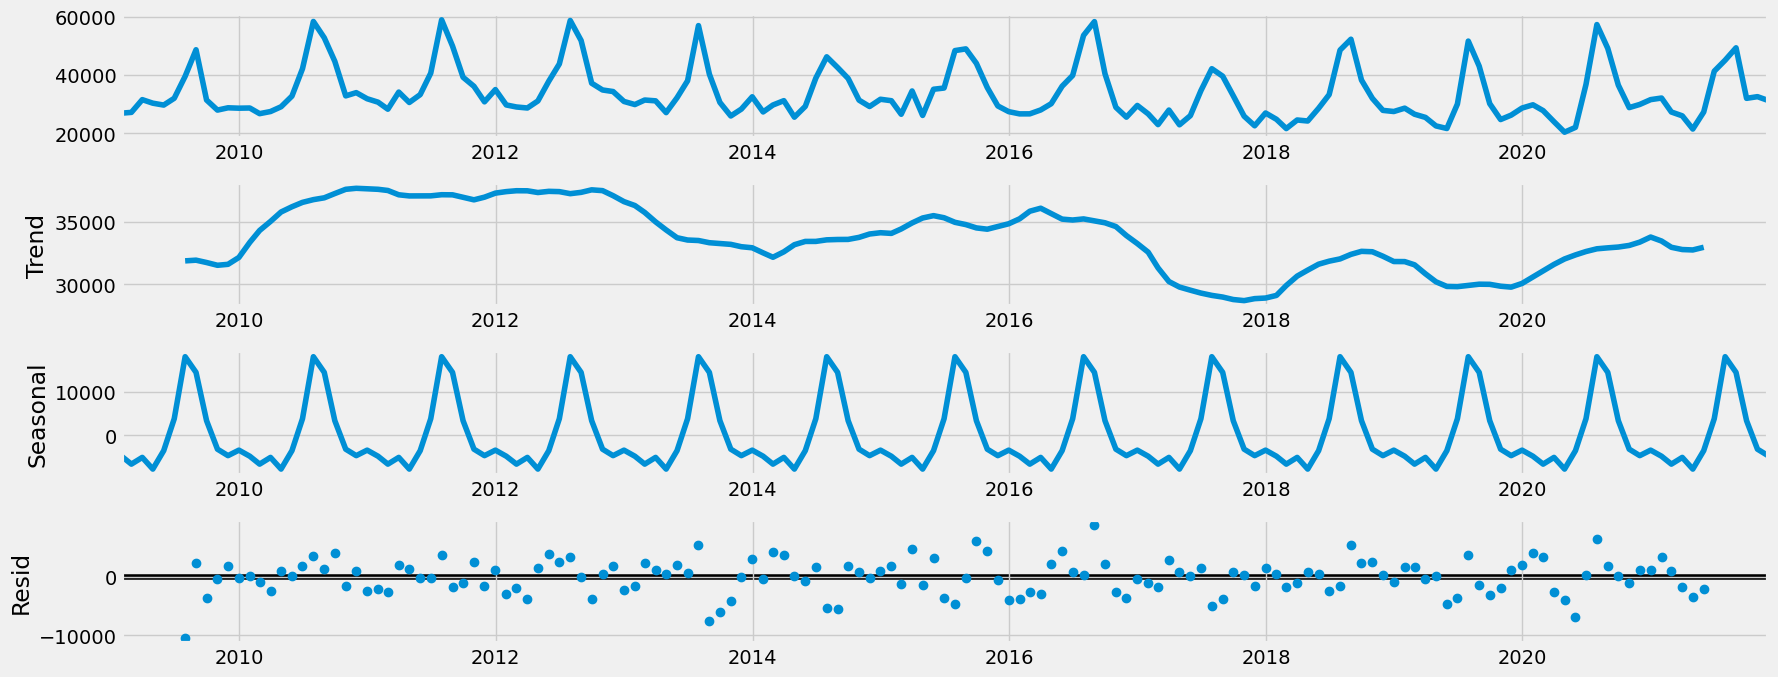

In [67]:
# Plot the separate components

decomposition.plot()
plt.show()

There is a seasonality which is expectable since we are looking at monthly receipts and energy needs tend very between months/seasons, we can also see some noise and the trend seens to show a mean value which is not constant, so the dataset does not seem to be stationary.

### 4. Testing for stationarity

In [68]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why I need to define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.157549
p-value                          0.222012
Number of Lags Used             13.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In this case, the test statistics is larger than the critical value so i can't reject the null hypothesis (If the test statistic is larger than the critical value, I can’t reject the null hypothesis. If the test statistic is smaller, then I can reject the null hypothesis). Also, the p-value is higher than 0.05, which indicates this result is not significant. Moving on to testing for autocorrelation to help understand if the data is stationary.

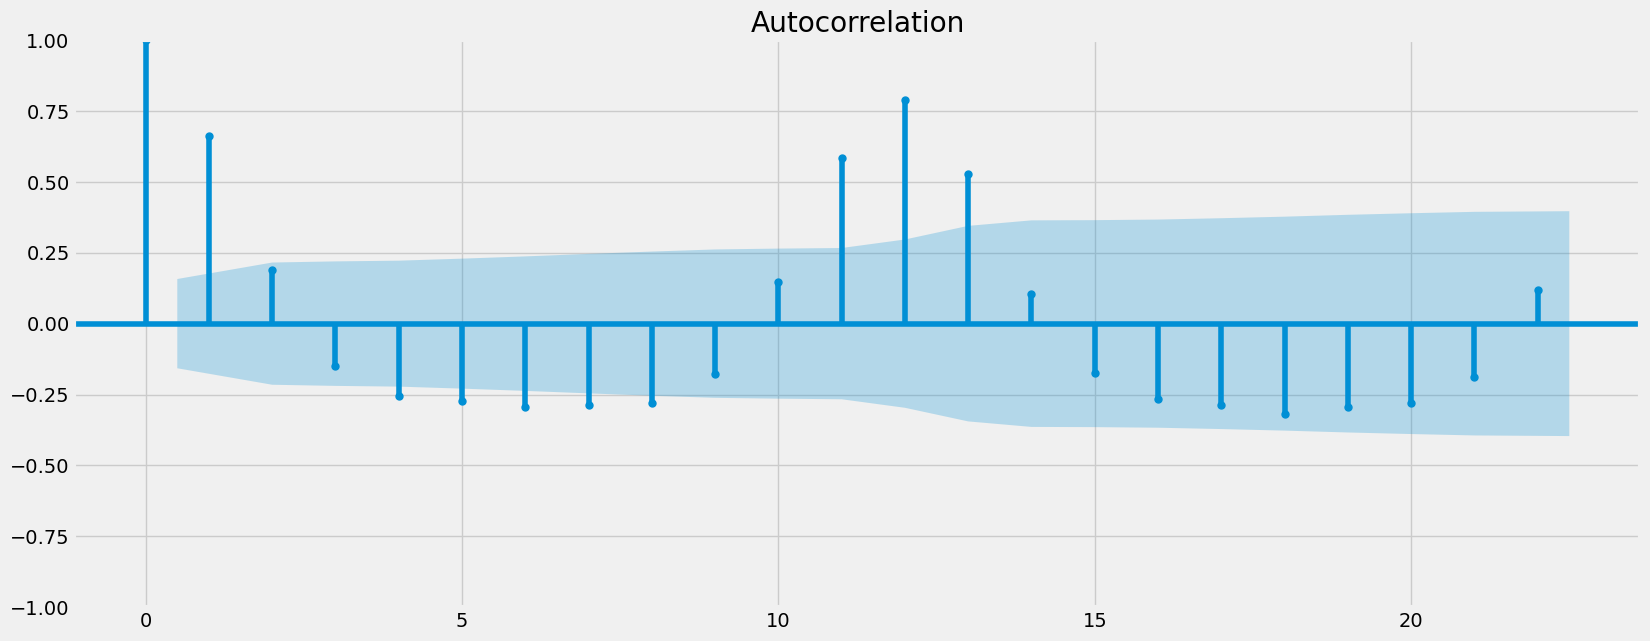

In [69]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

There are some autocorrelations which indicate that the stationarity of the data is weak. We have some lags that go above the blue edge indicating these lags are significantly correlated to each other. Although we only have five lags that are out of the confidence interval.

### 5. Stationarizing US Energy Information on Fossil Fuel Receipts

In [70]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [71]:
data_diff.dropna(inplace = True) # Here, remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [72]:
data_diff.head()

,Value
datetime,
2009-02-28,266.572
2009-03-31,4368.455
2009-04-30,-1213.759
2009-05-31,-649.243
2009-06-30,2338.409


In [73]:
data_diff.columns

Index(['Value'], dtype='object')

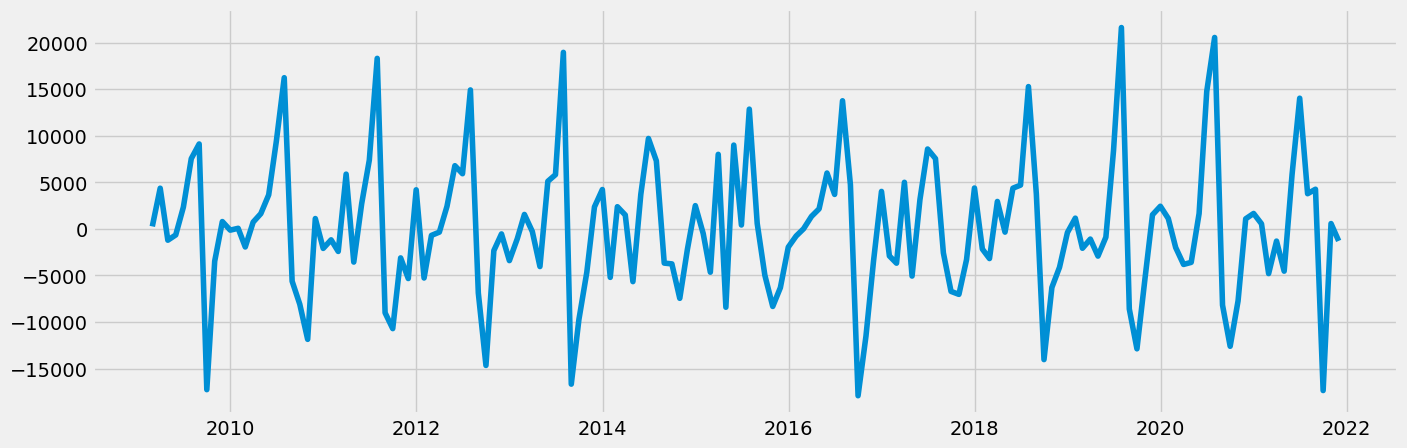

In [74]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [75]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.502056
p-value                          0.000195
Number of Lags Used             12.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


After differentiating, the p-value shows that the results are statistically significant, and the test statistic (-4.5) is smaller than the critical value (-3.4), so we can reject the null hyothesis. There is no unit root, and the data is stationary so we can proceed with the forecast analyis.

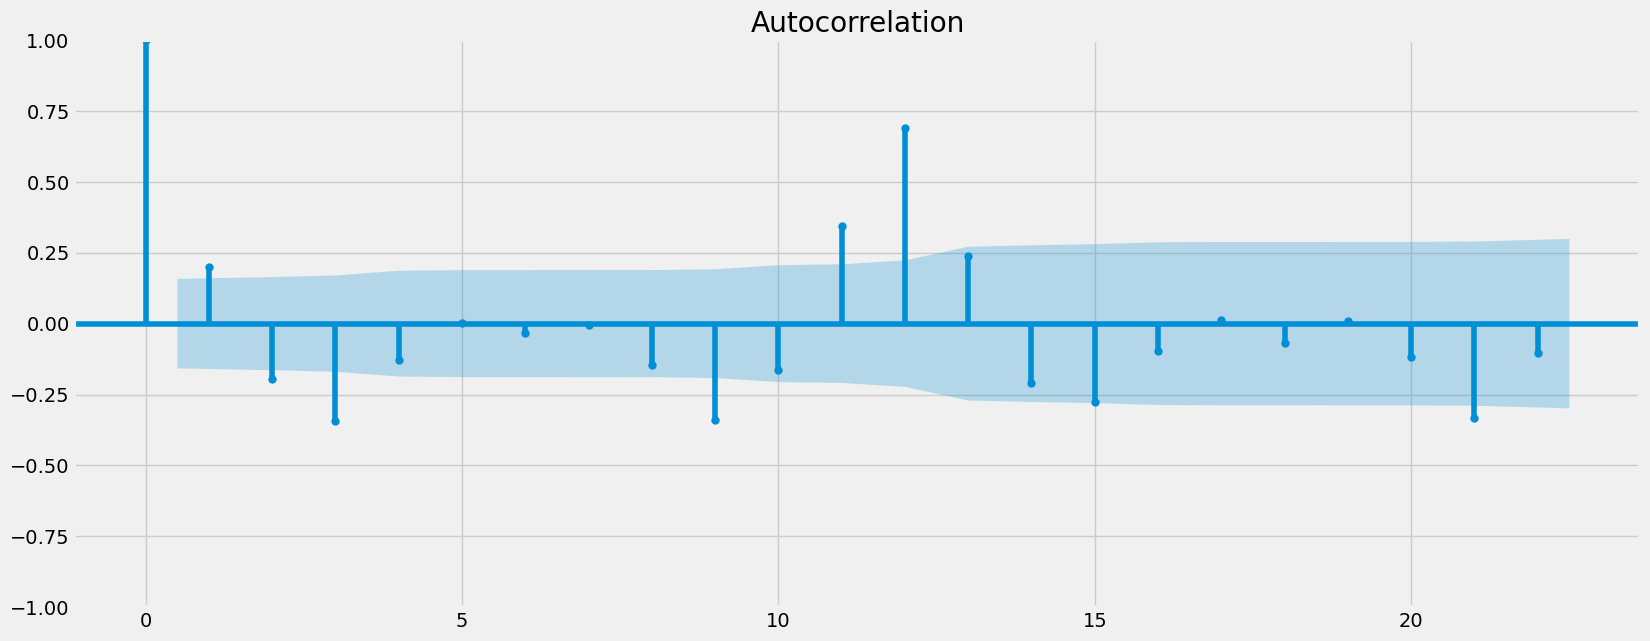

In [76]:
plot_acf(data_diff)
plt.show()

After differentiating, the data also shows no significant outcorrelations outside the confidence interval.